<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/film_flitering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

フィルム画像をダウンロードする

In [0]:
!wget --no-check-certificate --show-progress -q\
    "https://www.dropbox.com/s/41o7i74fpsq5168/film.zip?dl=1" \
    -O "/tmp/film.zip"

import zipfile
import os
zip_ref = zipfile.ZipFile("/tmp/film.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

root_dir = "/tmp/film"

class_names = os.listdir(root_dir)

train, test, val = {}, {}, {}
train_files, test_files, val_files = {}, {}, {}
for class_name in class_names:
    train_files[class_name] = os.listdir(root_dir + '/' + class_name)
print("#training data: %s" % ([(k,len(v)) for (k,v) in train_files.items()]))
train['files'] = train_files

/tmp/film.zip       100%[===================>]   2.91M  3.98MB/s    in 0.7s    
#training data: [('wrinkled', 3), ('normal', 1)]


画像を1枚読み込んでサイズを調べる

In [0]:
train['dir'] = root_dir
cn = class_names[0]
from PIL import Image
im = Image.open(train['dir'] + '/' + cn + '/' + train['files'][cn][0])
org_size = im.height, im.width
print("image size:", org_size)

image size: (512, 2048)


ディレクトリから画像をランダムに読み込む準備

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator#, load_img, img_to_array

train['gen'] = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.,
    height_shift_range=0.,
    horizontal_flip=False)

train['flow'] = train['gen'].flow_from_directory(train['dir'], class_mode="binary", target_size=org_size, color_mode = "grayscale", batch_size=8)
cid_to_class_name = {train['flow'].class_indices[name]: name for name in class_names}

Found 4 images belonging to 2 classes.


試しに数枚読み込んで表示する

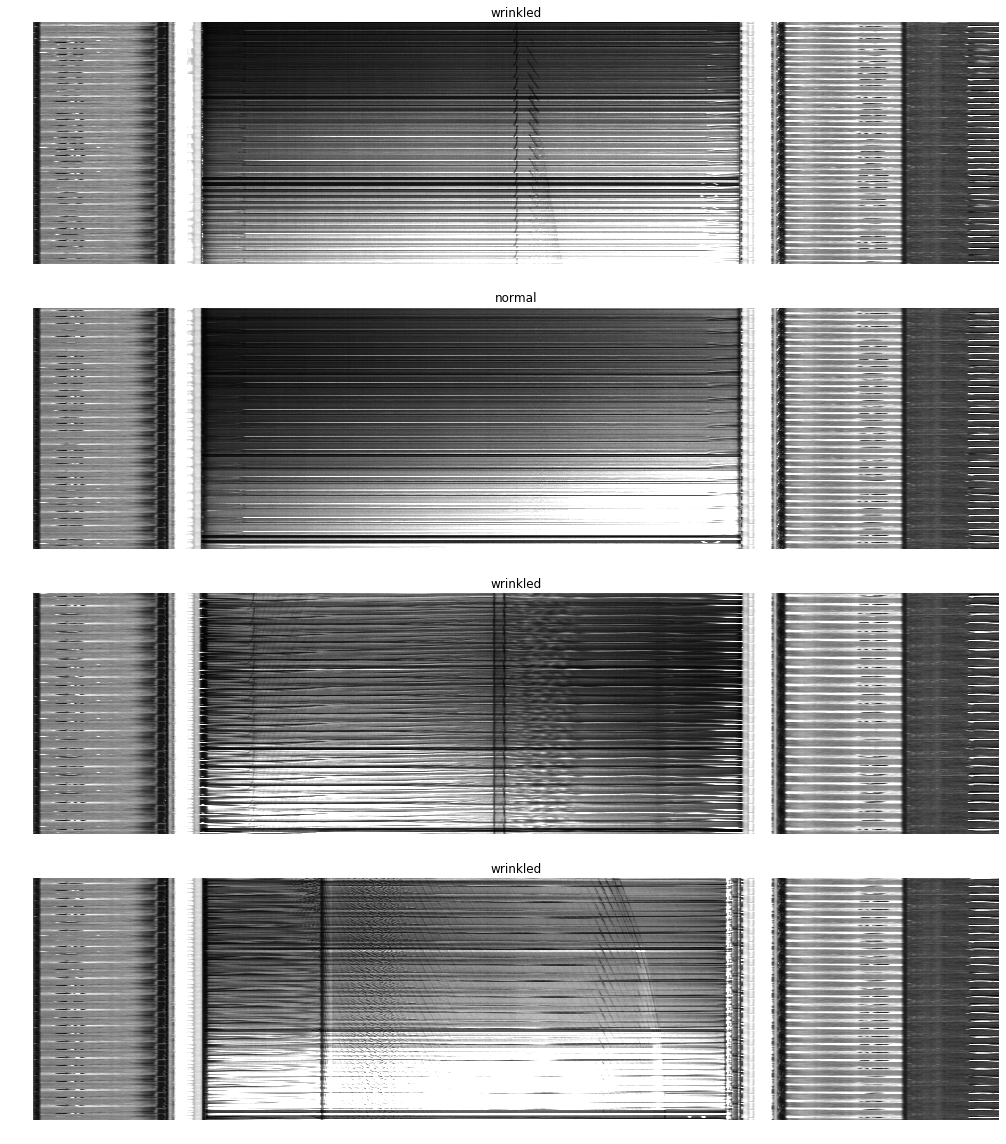

In [0]:
%matplotlib inline

# Randomly show some images from the generator
import matplotlib.pyplot as plt
import numpy as np

def plotImages(img_arr, lbl_arr):
    nfigs = min(len(img_arr), 5)
    fig, axes = plt.subplots(nfigs, 1, figsize=(nfigs*18,nfigs*4))
    if nfigs == 1: axes =np.array(axes)
    axes = axes.flatten()
    for img, lbl, ax in zip( img_arr, lbl_arr, axes):
        ax.imshow(img[:,:,0], cmap='gray')#, vmin=-1, vmax=1)
        ax.title.set_text(cid_to_class_name[lbl])
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
image_batch, label_batch = next(train['flow'])
plotImages(image_batch, label_batch)

左右を切り取って表示する

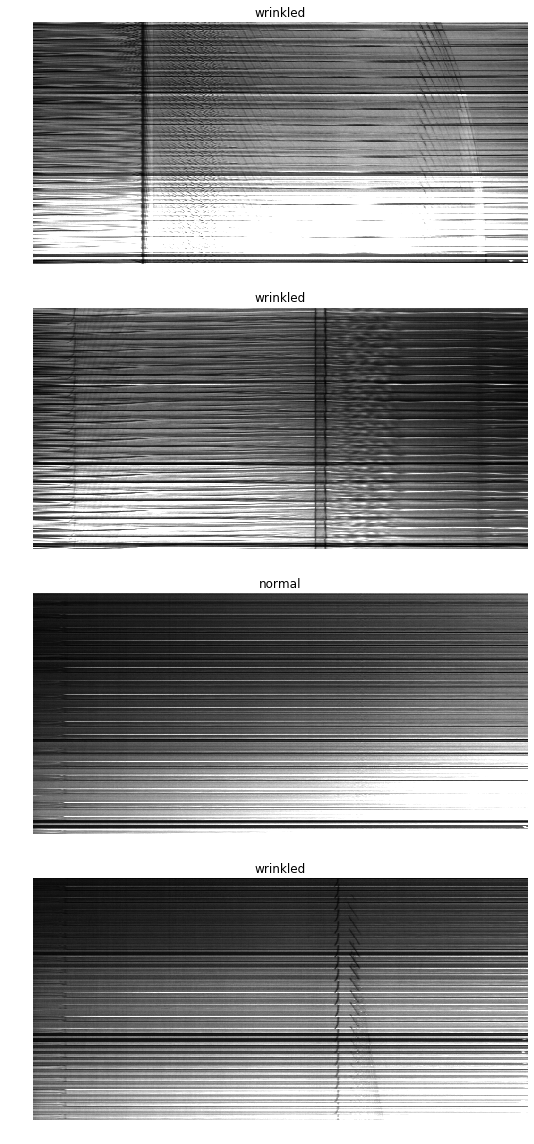

In [0]:
cl = 380
cr = 620
image_batch, label_batch = next(train['flow'])

image_batch_cropped = image_batch[:,:,cl:-cr,:]
plotImages(image_batch_cropped, label_batch)

横方向の差分画像を作り，最大値フィルタまたは佐藤フィルタの大津閾値が大きかったら二値化してみる

In [0]:
img_id = 3 # 0,..,3
D = image_batch_cropped[img_id,:,:,0] / 255.

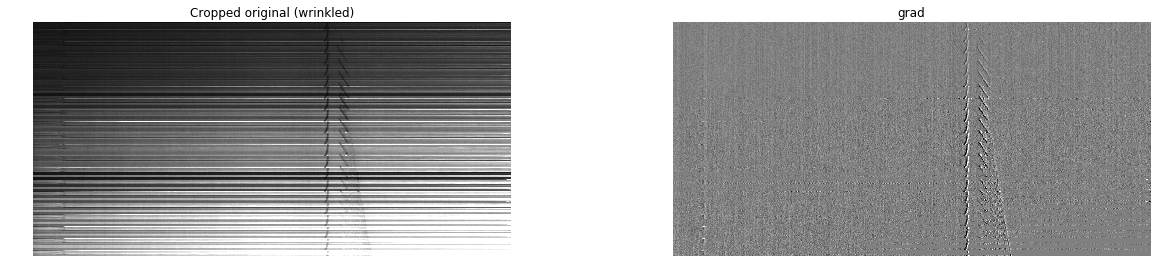

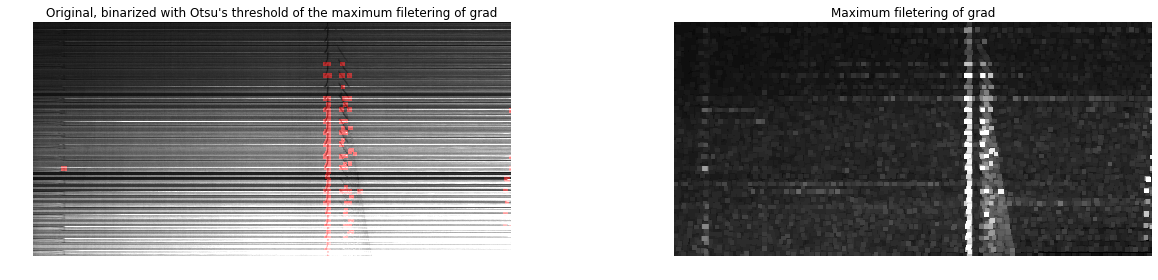

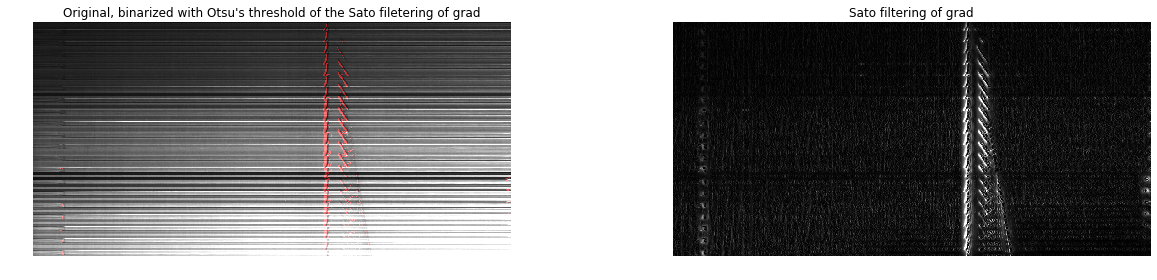

In [0]:
import numpy as np
from scipy import ndimage
from skimage import filters

# Original image and its grad
fig = plt.figure(figsize=(18, 4))
fig.add_subplot(1,2,1)
plt.imshow(D, cmap='gray', vmin=0, vmax=1)
plt.gca().title.set_text("Cropped original ("+cid_to_class_name[label_batch[img_id]]+")")
plt.gca().axis('off')

Dxdif = np.diff(D)

fig.add_subplot(1,2,2)
plt.imshow(Dxdif, cmap='gray', vmin=-0.1, vmax=0.1)
plt.gca().title.set_text("grad")
plt.gca().axis('off')

plt.tight_layout()
plt.show()


# Original with max. filt. mask
Dmaxf = ndimage.maximum_filter(Dxdif, size=10)
th = filters.threshold_otsu(Dmaxf)
#print(th, np.median(Dmaxf.ravel()))
if th < np.median(Dmaxf.ravel())*2: th = np.inf
Pmaxf = D[:,:-1] * 255.
Pmaxf[Dmaxf > th] += 127.
Dw = np.dstack((np.minimum(Pmaxf, 255), D[:,:-1]*255., D[:,:-1]*255.)).astype(np.uint8) 

fig = plt.figure(figsize=(18, 4))
fig.add_subplot(1,2,2)
plt.imshow(Dmaxf, cmap='gray', vmin=0, vmax=0.2)
plt.gca().title.set_text("Maximum filetering of grad")
plt.gca().axis('off')
fig.add_subplot(1,2,1)
plt.imshow(Dw)
plt.gca().title.set_text("Original, binarized with Otsu's threshold of the maximum filetering of grad")
plt.gca().axis('off')
plt.tight_layout()
plt.show()



# Original with sato filt. mask
Dsatof = filters.sato(Dxdif)
Psatof = D[:,:-1] * 255.
th = filters.threshold_otsu(Dsatof)
#print(th, np.median(Dsatof.ravel()))
if th < np.median(Dsatof.ravel())*2: th = np.inf
Psatof[Dsatof > th] += 127.
Dw = np.dstack((np.minimum(Psatof, 255), D[:,:-1]*255., D[:,:-1]*255.)).astype(np.uint8) 


fig = plt.figure(figsize=(18, 4))
fig.add_subplot(1,2,2)
plt.imshow(Dsatof, cmap='gray', vmin=0, vmax=0.02)
plt.gca().title.set_text("Sato filtering of grad")
plt.gca().axis('off')
fig.add_subplot(1,2,1)
plt.imshow(Dw)
plt.gca().title.set_text("Original, binarized with Otsu's threshold of the Sato filetering of grad")
plt.gca().axis('off')
plt.tight_layout()
plt.show()

